<a href="https://colab.research.google.com/github/Anushka-Punukollu/SeaBloom/blob/main/SeaBloomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Buliding Convolutional Neural Networks (CNNs) to Stop Coral Bleaching : A SeaBloom Approach 🪸🌊** 


**Idea Further Explained: https://medium.com/@AnushkaPunukollu/seabloom-fab26eec2aea**

In [103]:
#Import Required Libraries 

# Data Manipulation and Analysis Libraries
import numpy as np 
import pandas as pd
from sklearn import metrics

# Data Visualization Libraries
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

# Deep Learning (DL) Libraries
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Computer Vision (CV) Libraries
import torchvision 
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models 

# File and Directory Manipulation Libraries
import pathlib
import os

# The code above sets a configuration option to False for the Jedi autocomplete plugin.
%config Completer.use_jedi = False

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# Listing the contents of the '/content/drive' directory
!ls '/content/drive'

MyDrive


In [106]:
# Checking if CUDA (GPU) is available, and if so, using it as the device, otherwise using CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
# Set path to the training dataset directory
train_path = '/content/drive/MyDrive/Coral-Bleaching-DataSet/Testing'

# Set path to the testing dataset directory
test_path = '/content/drive/MyDrive/Coral-Bleaching-DataSet/Training'

In [108]:
# Defining the transformation pipeline for transforms1
transform = transforms.Compose(
[
    # Resizes the image to (164, 164)
    transforms.Resize((164, 164)),
 
    # Converts the image to grayscale
    transforms.Grayscale(num_output_channels=1),
  
    # Convert images (png) into PyTorch tensors
    transforms.ToTensor()
])

# Defining the transformation pipeline for transforms2
transforms2 = transforms.Compose(
[
    # Performs random autocontrast on the image
    transforms.RandomAutocontrast(),

    # Randomly adjusts the brightness, contrast, saturation, and hue of the image (AKA: adds "jitter")
    transforms.ColorJitter(),

    # Resizes the image to (164, 164)
    transforms.Resize((164, 164)),
 
    # Converts the image to grayscale
    transforms.Grayscale(num_output_channels=1), 

    # Convert images (png) into PyTorch tensors
    transforms.ToTensor()
])

# Creating ImageFolder datasets with different transformations
train_data1 = datasets.ImageFolder(train_path, transform=transform)
train_data2 = datasets.ImageFolder(train_path, transform=transforms2)
test_data = datasets.ImageFolder(test_path, transform=transform)

# Concatenating the train_data1 and train_data2 datasets
combined_data = torch.utils.data.ConcatDataset([train_data1, train_data2])

# Splitting the concatenated dataset into validation (229 images) and training datasets (459 images)
valid_data, train_data = torch.utils.data.random_split(combined_data, [229, 459])

# Data Loaders 
batch_size = 32

# Creating a data loader for the training data
train_load = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Creating a data loader for the testing data
test_load = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Creating a data loader for the validation data
valid_load = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [109]:
# Print the length of the train_data
print(len(train_data))

# Create an iterator for the train_loader
dataiter = iter(train_load)

# Get the next batch of data from the iterator
images, labels = next(dataiter)

# Convert the images tensor to a NumPy array
images = images.numpy()

# Print the shape of the images array
print(images.shape)

459
(32, 1, 164, 164)


['Bleached', 'Unbleached']


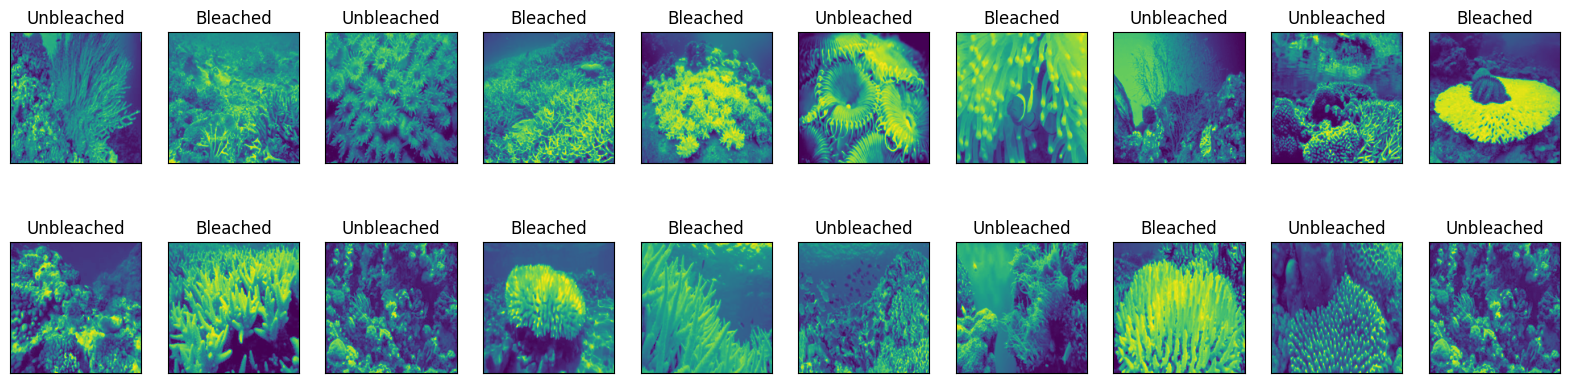

In [111]:
# Get the classes from the test_loader dataset then print it
classes = test_load.dataset.classes
print(classes)

# Function to display the images [bleached, unbleached]
def imshow(im):
  # change 1,2,0
    plt.imshow(np.transpose(im, (1, 2, 0)))

# Visualize the data
fig = plt.figure(figsize=(20,5))
for i in range (20):
    ax = fig.add_subplot(2, int(20/2), i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

In [112]:
# Convolution network 
class Convolution(nn.Module):
    def __init__(self, inp, out):
        super(Convolution, self).__init__()
        self.conv1 = nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm2d(out)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
    def forward(self, y):
        y = self.pool(self.norm(self.relu(self.conv1(y))))
        return y

# Model Network 
class Model_Network(nn.Module):
    def __init__(self):
        super(Model_Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(1, affine=False)
        self.layer1 = Convolution(inp=1, out=8)
        self.layer2 = Convolution(inp=8, out=16)
        self.layer3 = Convolution(inp=16, out=32)
        self.layer4 = Convolution(inp=32, out=64)
        self.layer5 = Convolution(inp=64, out=128)
        self.layer6 = Convolution(inp=128, out=256)
        self.layer7 = Convolution(inp=256, out=512)
        
        self.net = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6, self.layer7)
       
        self.fc1 = torch.nn.Linear(in_features=512, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)
        self.fc4 = torch.nn.Linear(in_features=8, out_features=4)
        
        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2, self.fc3, self.bn3, self.fc4)  
        
    def forward(self, y):
        y = self.net(y)
        y = y.view(y.size(0), -1)
        y = self.lin(y)
        return y

# Create an instance of the Model_Network
Model = Model_Network()

In [113]:
# Define the loss function
crit = nn.CrossEntropyLoss()

# Define the optimizer
optim = optim.Adam(Model.parameters(), lr=1.0E-3)

In [99]:
epochs = 30
min_loss = 100

train_losses = []
valid_losses = []

# Loop through the specified number of epochs
for i in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    # Set the model to training mode
    Model.train()
    
    # Iterate over the training data
    for images, labels in train_load:
        # Clear the gradients
        optim.zero_grad()
        
        # Forward pass: compute the output
        output = Model(images)
        
        # Calculate the loss
        loss = crit(output, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update the weights and biases
        optim.step()

        # Update the training loss
        train_loss += loss.item() * labels.size(0)
        
    # Set the model to evaluation mode
    Model.eval()
    
    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for images, labels in valid_load:
            # Forward pass: compute the output
            output = Model(images)
            
            # Calculate the loss
            loss = crit(output, labels)
            
            # Update the validation loss
            valid_loss += loss.item() * labels.size(0)
    
    # Calculate the average training and validation losses
    total_train_loss = train_loss / len(train_load)
    total_valid_loss = valid_loss / len(valid_load)
    
    # Append the losses to the respective lists
    train_losses.append(total_train_loss)
    valid_losses.append(total_valid_loss)

    # Print the epoch number, validation loss, and training loss
    print("\nEpoch # {} \nValidation Loss: {} \nTraining Loss: {}".format(i, total_valid_loss, total_train_loss))
    
    # Check if the validation loss decreased
    if total_valid_loss < min_loss: 
        print("Loss Decreased {} → {}".format(min_loss, total_valid_loss))
        min_loss = total_valid_loss

# Print a message indicating the completion of training
print("\nCongrats, training done!!! 🙌🎊")


Epoch # 0 
Validation Loss: 40.743184953927994 
Training Loss: 30.008547210693358
Loss Decreased 100 → 40.743184953927994

Epoch # 1 
Validation Loss: 50.39742587506771 
Training Loss: 21.364305686950683

Epoch # 2 
Validation Loss: 35.645468562841415 
Training Loss: 18.268532466888427
Loss Decreased 40.743184953927994 → 35.645468562841415

Epoch # 3 
Validation Loss: 25.216323792934418 
Training Loss: 14.666562281052272
Loss Decreased 35.645468562841415 → 25.216323792934418

Epoch # 4 
Validation Loss: 17.5647095143795 
Training Loss: 12.447146956125895
Loss Decreased 25.216323792934418 → 17.5647095143795

Epoch # 5 
Validation Loss: 10.803476002067327 
Training Loss: 10.441577446460723
Loss Decreased 17.5647095143795 → 10.803476002067327

Epoch # 6 
Validation Loss: 10.433634147047997 
Training Loss: 8.704124677181245
Loss Decreased 10.803476002067327 → 10.433634147047997

Epoch # 7 
Validation Loss: 8.944929778575897 
Training Loss: 7.487990438938141
Loss Decreased 10.4336341470479

In [101]:
test_loss = 0.0
class_right = list(0. for i in range(4))
class_total = list(0. for i in range(4))

# Set the model to evaluation mode
Model.eval()

# Iterate over the test data
for images, labels in test_load:
    optim.zero_grad()
    out = Model(images)
    loss = crit(out, labels)
    test_loss += loss.item()
    _, pred = torch.max(out, 1)
    right_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(right_tensor.numpy())
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_right[label] += correct[i].item()
        class_total[label] += 1

# Calculate the overall test accuracy
test_accuracy = 100. * np.sum(class_right) / np.sum(class_total)

# Print the overall test accuracy
print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (test_accuracy, np.sum(class_right), np.sum(class_total)))

Test Accuracy (Overall): 98% (339/344)


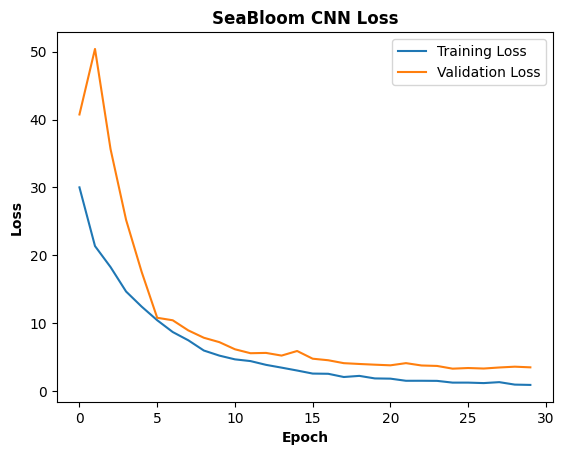

In [102]:
plt.title('SeaBloom CNN Loss', weight='bold')
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Loss', weight='bold')
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), valid_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()